# Problem 1 
We denoise Goldhill and Lena images with 3 different methods:

- Gaussian
- Median
- Bilateral

Then also apply the following sharpening filters to each image:
- Laplacian



In [13]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt

In [14]:
# image imports
lena_original_path = os.path.join('imgs', 'lena_ori.png')
lena_noisy_path = os.path.join('imgs', 'lena_noisy.png')
goldhill_original_path = os.path.join('imgs', 'Goldhill_2.jpg')
goldhill_noisy_path = os.path.join('imgs', 'Goldhill_2noisy.jpg')

# read images
lena_original = cv2.imread(lena_original_path)
lena_noisy = cv2.imread(lena_noisy_path)
goldhill_original = cv2.imread(goldhill_original_path)
goldhill_noisy = cv2.imread(goldhill_noisy_path)

def laplacian_sharpen(image, alpha=0.15, blur_ksize=3, ksize=1):
    image_f = image.astype(np.float32)
    smoothed = cv2.GaussianBlur(image_f, (blur_ksize, blur_ksize), 0)
    lap = cv2.Laplacian(smoothed, cv2.CV_32F, ksize=ksize)
    out = np.clip(image_f - alpha * lap, 0, 255)
    return out.astype(np.uint8)

denoise_param_sets = {
    "Goldhill": {
        "gaussian_ksize": 3,
        "median_ksize": 3,
        "bilateral": (15, 25, 10),
    },
    "Lena": {
        "gaussian_ksize": 9,
        "median_ksize": 9,
        "bilateral": (9, 200, 10),
    },
}

sharpen_param_sets = {
    "Goldhill": {
        "gaussian": {"alpha": 0.08, "blur_ksize": 3, "ksize": 3},
        "median": {"alpha": 0.08, "blur_ksize": 5, "ksize": 3},
        "bilateral": {"alpha": 0.15, "blur_ksize": 7, "ksize": 3},
    },
    "Lena": {
        "gaussian": {"alpha": 0.02, "blur_ksize": 3, "ksize": 5},
        "median": {"alpha": 0.04, "blur_ksize": 9, "ksize": 5},
        "bilateral": {"alpha": 0.02, "blur_ksize": 5, "ksize": 5},
    },
}

def get_image_key(name):
    return "Goldhill" if "Goldhill" in name else "Lena"

def apply_denoise_methods(name, image):
    cfg = denoise_param_sets[get_image_key(name)]
    return [
        ("Gaussian", cv2.GaussianBlur(image, (cfg["gaussian_ksize"], cfg["gaussian_ksize"]), 0)),
        ("Median", cv2.medianBlur(image, cfg["median_ksize"])),
        ("Bilateral", cv2.bilateralFilter(image, *cfg["bilateral"])),
    ]

image_configs = [
    ("Goldhill", goldhill_original, goldhill_noisy),
    ("Lena", lena_original, lena_noisy),
]

processed_images = []

for name, original, noisy in image_configs:
    noisy_aligned = noisy
    if noisy_aligned.shape != original.shape:
        noisy_aligned = cv2.resize(noisy_aligned, (original.shape[1], original.shape[0]))

    psnr_noisy = cv2.PSNR(original, noisy_aligned)

    method_results = []
    for method_name, denoised in apply_denoise_methods(name, noisy_aligned):
        img_key = get_image_key(name)
        method_key = method_name.lower()
        sharpen_params = sharpen_param_sets[img_key][method_key]
        sharpened = laplacian_sharpen(denoised, **sharpen_params)

        method_results.append({
            "method": method_name,
            "denoised": denoised,
            "sharpened": sharpened,
            "psnr_denoised": cv2.PSNR(original, denoised),
            "psnr_sharpened": cv2.PSNR(original, sharpened),
        })

    processed_images.append({
        "name": name,
        "original": original,
        "noisy": noisy_aligned,
        "psnr_noisy": psnr_noisy,
        "methods": method_results,
    })

results = []
for item in processed_images:
    results.append({
        "name": item["name"],
        "psnr_noisy": item["psnr_noisy"],
        "methods": [
            (m["method"], m["psnr_denoised"], m["psnr_sharpened"])
            for m in item["methods"]
        ],
    })

print("PSNR: Table Results")
print("=" * 90)
print(f"{'Noisy Image':<12} {'Method':<12} {'Noisy (vs orig)':<18} {'Denoised only':<18} {'Denoised+Sharpened':<20}")
print("-" * 90)
for r in results:
    for i, (method, psnr_denoised, psnr_sharpened) in enumerate(r["methods"]):
        print(f"{r['name']:<12} {method:<12} {r['psnr_noisy']:<18.2f} {psnr_denoised:<18.2f} {psnr_sharpened:<20.2f}")
    print("-" * 90)


PSNR: Table Results
Noisy Image  Method       Noisy (vs orig)    Denoised only      Denoised+Sharpened  
------------------------------------------------------------------------------------------
Goldhill     Gaussian     28.76              28.77              28.82               
Goldhill     Median       28.76              28.70              28.71               
Goldhill     Bilateral    28.76              29.15              29.21               
------------------------------------------------------------------------------------------
Lena         Gaussian     20.13              28.16              28.36               
Lena         Median       20.13              26.62              26.78               
Lena         Bilateral    20.13              28.46              28.56               
------------------------------------------------------------------------------------------


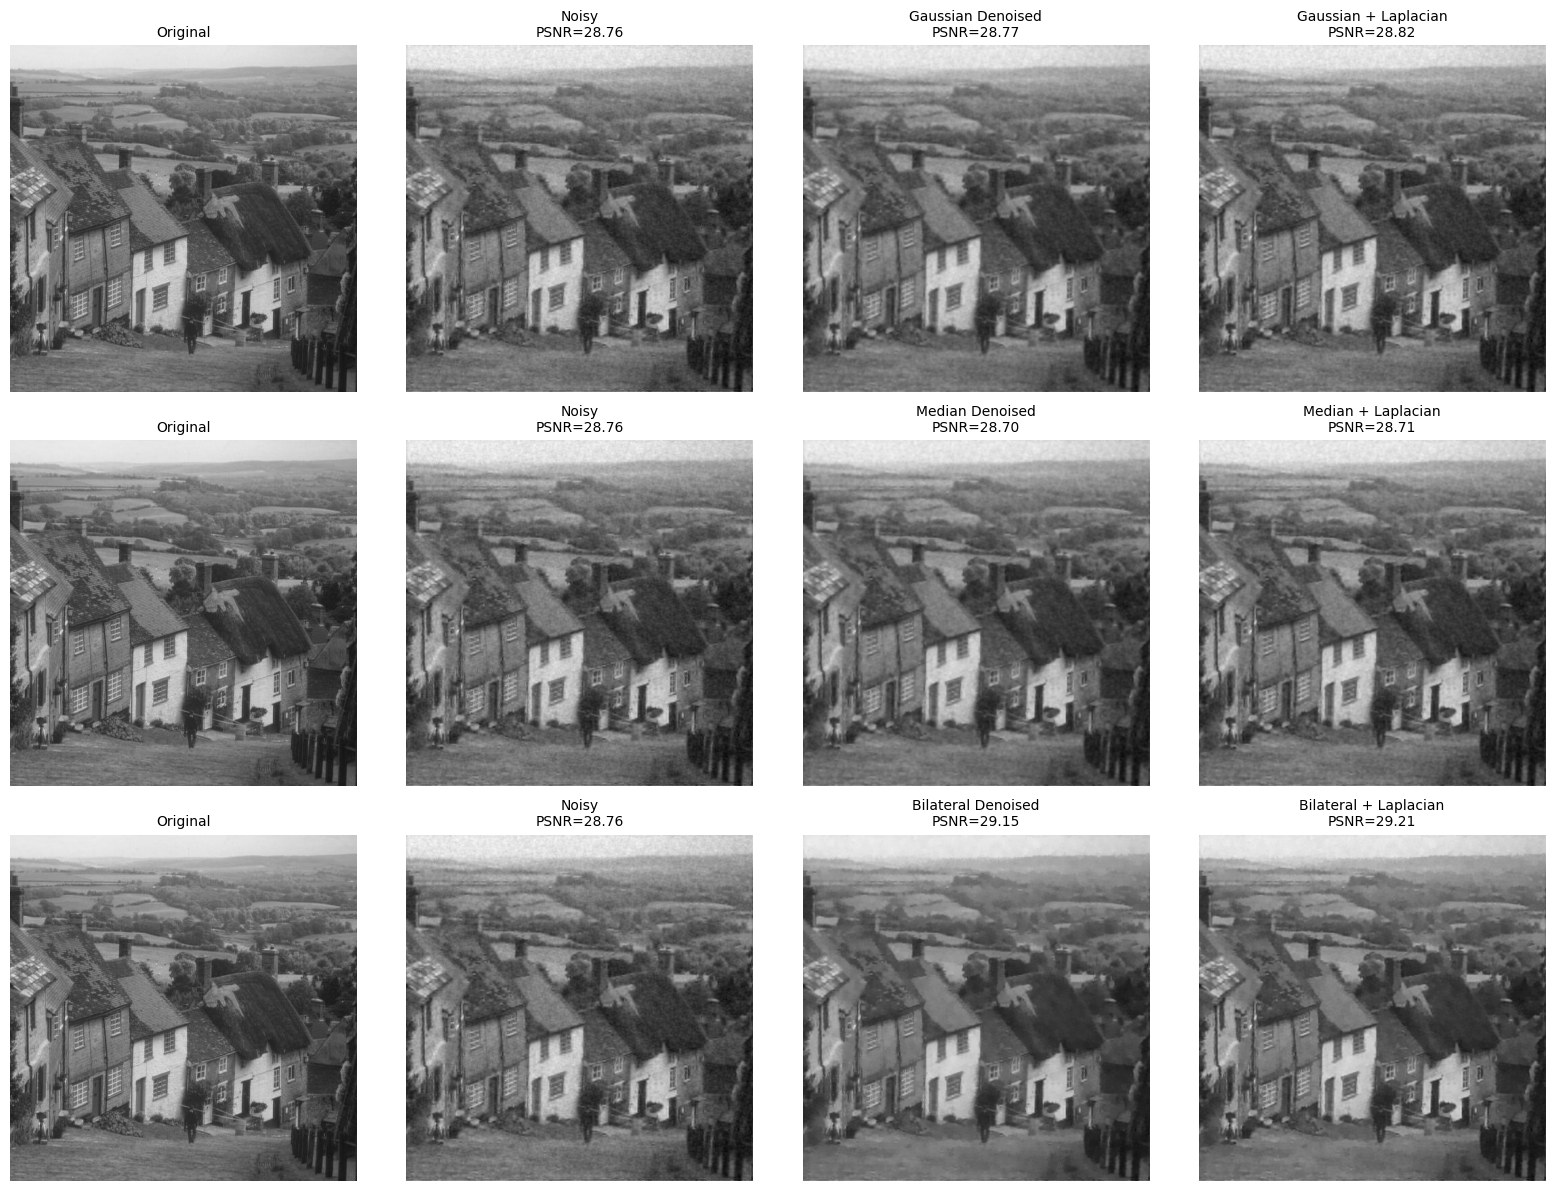

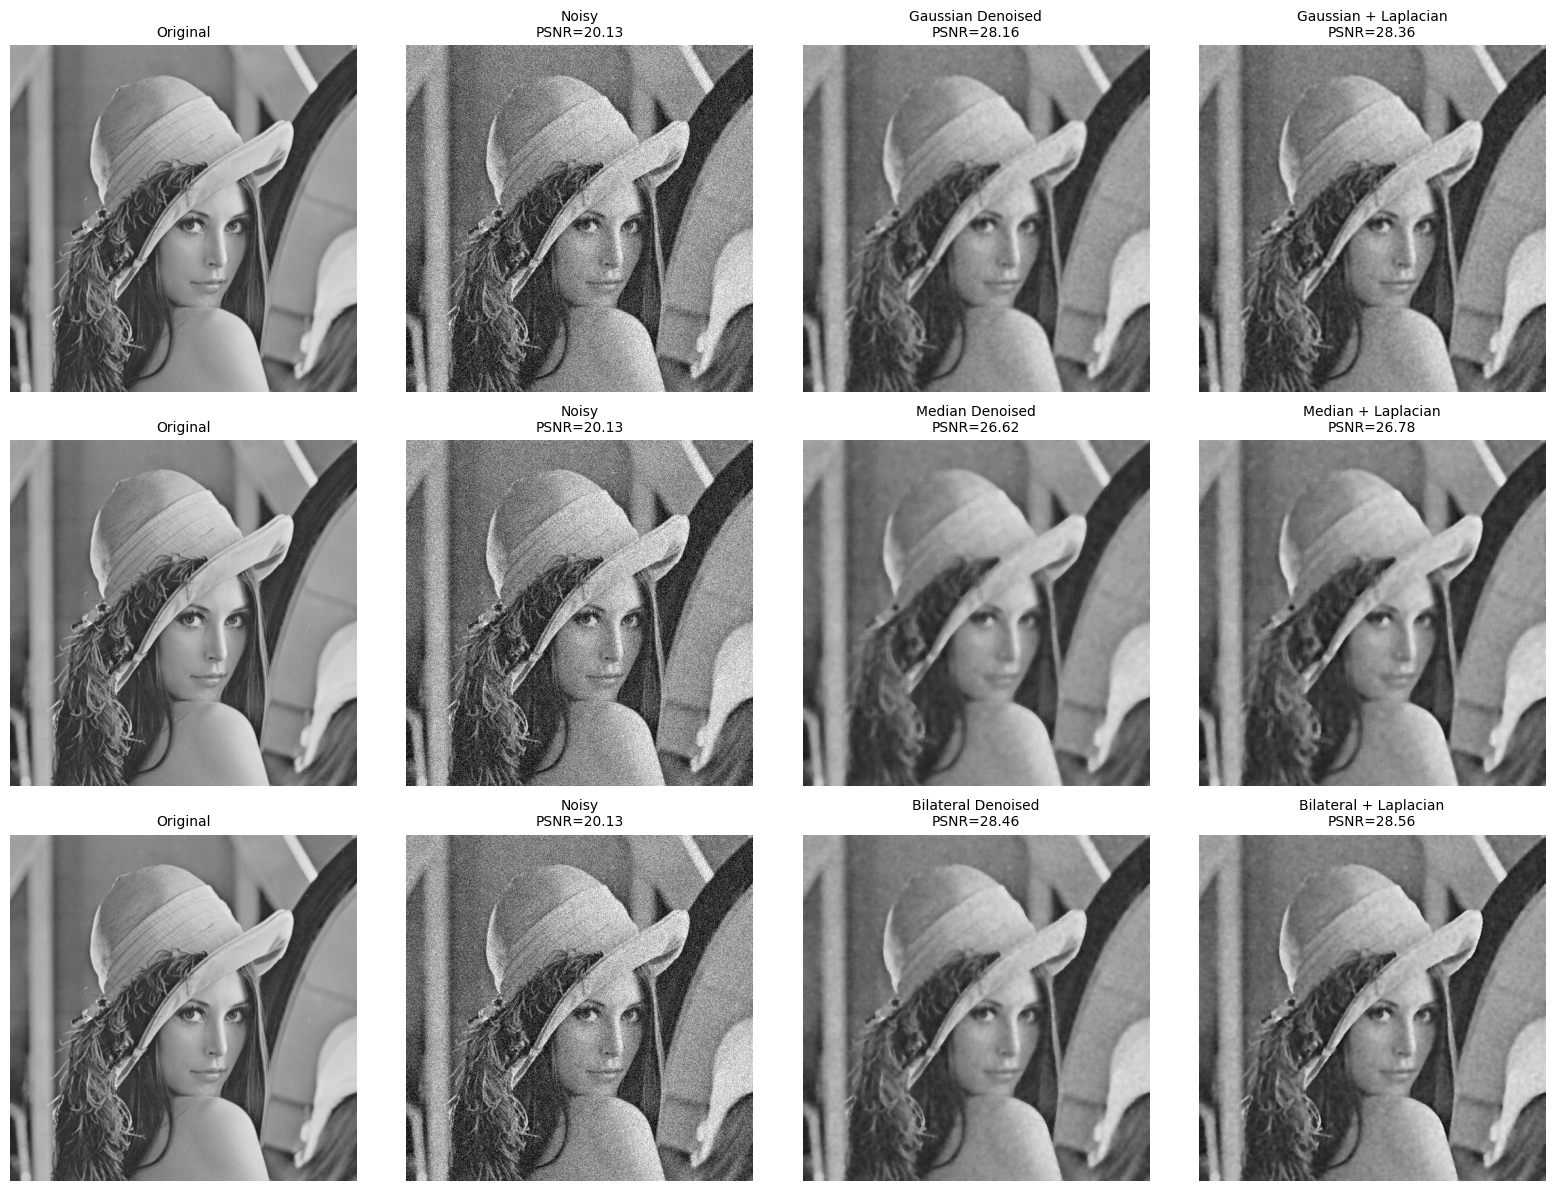

In [15]:
def bgr_to_rgb(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)


for item in processed_images:
    name = item["name"]
    original = item["original"]
    noisy = item["noisy"]
    psnr_noisy = item["psnr_noisy"]
    method_results = item["methods"]

    fig, axes = plt.subplots(len(method_results), 4, figsize=(16, 12))

    for r, method_result in enumerate(method_results):
        method_name = method_result["method"]
        denoised = method_result["denoised"]
        sharpened = method_result["sharpened"]
        psnr_denoised = method_result["psnr_denoised"]
        psnr_sharp = method_result["psnr_sharpened"]

        panels = [
            (original, "Original"),
            (noisy, f"Noisy\nPSNR={psnr_noisy:.2f}"),
            (denoised, f"{method_name} Denoised\nPSNR={psnr_denoised:.2f}"),
            (sharpened, f"{method_name} + Laplacian\nPSNR={psnr_sharp:.2f}"),
        ]

        for c, (img, title) in enumerate(panels):
            ax = axes[r, c]
            ax.imshow(bgr_to_rgb(img))
            ax.set_title(title, fontsize=10)
            ax.axis("off")

    plt.tight_layout()
    plt.show()


In [16]:
output_dir = 'imgs'
method_suffix = {
    "Gaussian": "gaussian",
    "Median": "median",
    "Bilateral": "bilateral",
}

def save_sharpened_images(processed_images, output_dir='imgs'):
    saved_paths = []
    for item in processed_images:
        prefix = "goldhill" if "Goldhill" in item["name"] else "lena"
        for method_result in item["methods"]:
            method_name = method_result["method"]
            suffix = method_suffix[method_name]
            out_path = os.path.join(output_dir, f'{prefix}_{suffix}_sharpened.png')
            cv2.imwrite(out_path, method_result["sharpened"])
            saved_paths.append(out_path)
    return saved_paths

saved_paths = save_sharpened_images(processed_images, output_dir)
